In [1]:
import re
import nltk
import spacy
import gensim
import nlp
import pandas as pd
import numpy as np
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
# Load corpus, texts and dictionary
with open('data/m-uniq/texts.pkl', 'rb') as f:
    texts = pickle.load(f)
id2word= corpora.Dictionary.load('data/m-uniq/id2word')

In [3]:
print(id2word)

Dictionary<42894 unique tokens: ['abiotic_environment', 'across_environment', 'biology', 'bridge', 'cause']...>


In [4]:
len(texts)

13701

In [5]:
texts_nonnull =[t for t in texts if len(t) > 0]
len(texts_nonnull)

13526

In [6]:
corpus = [id2word.doc2bow(t) for t in texts_nonnull]

In [7]:
def get_term_frequency(dictionary,cutoff_freq):
    """This returns a list of tuples (term,frequency) after removing all tuples with frequency smaller than cutoff_freq
       dictionary (gensim.corpora.Dictionary): corpus dictionary
       cutoff_freq (int): terms with whose frequency smaller than this will be dropped
    """
    tf = []
    for k,v in dictionary.dfs.items():
        tf.append((str(dictionary.get(k)),v))
    return tf

In [8]:
tf = get_term_frequency(id2word, 1)
sorted(tf, key=lambda t: t[1], reverse=True)[:100]

[('high', 1993),
 ('increase', 1986),
 ('pattern', 1963),
 ('dynamic', 1859),
 ('different', 1835),
 ('influence', 1830),
 ('structure', 1791),
 ('large', 1739),
 ('response', 1621),
 ('individual', 1616),
 ('important', 1594),
 ('distribution', 1561),
 ('diversity', 1532),
 ('abundance', 1505),
 ('base', 1482),
 ('competition', 1373),
 ('environment', 1369),
 ('variation', 1348),
 ('show', 1340),
 ('role', 1332),
 ('present', 1318),
 ('potential', 1299),
 ('impact', 1266),
 ('many', 1223),
 ('composition', 1215),
 ('associate', 1214),
 ('relationship', 1202),
 ('growth', 1188),
 ('measure', 1152),
 ('density', 1149),
 ('function', 1142),
 ('small', 1123),
 ('great', 1121),
 ('presence', 1106),
 ('climate', 1101),
 ('trait', 1093),
 ('common', 1091),
 ('resource', 1088),
 ('predator', 1085),
 ('organism', 1055),
 ('host', 1043),
 ('specific', 1034),
 ('similar', 1002),
 ('size', 991),
 ('strong', 942),
 ('ecology', 939),
 ('decrease', 927),
 ('relative', 909),
 ('environmental', 906),


In [9]:
print(corpus[:2])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 2), (7, 3), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 3), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 5), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)], [(10, 1), (34, 2), (35, 1), (36, 2), (37, 1), (38, 3), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 3), (63, 1), (64, 1), (65, 2), (66, 1)]]


In [10]:
print(texts[:2])

[['integrative', 'context_dependent', 'long_know', 'outcome', 'environmental_context', 'climate', 'spark', 'context_dependent', 'rapidly_change', 'abiotic_environment', 'cause', 'novel', 'context', 'environment', 'outcome', 'integrative', 'biology', 'trait', 'mechanism', 'bridge', 'discipline', 'physiology', 'quantifying', 'tolerance_environmental', 'independent', 'function', 'environment', 'mechanism_underlie', 'outcome', 'help_determine', 'outcome', 'relative_abundance', 'distribution', 'nature', 'general', 'unable', 'integrative', 'biology', 'paradigm', 'across_environment', 'physiological_mechanism', 'context', 'impact', 'outcome', 'context_dependent'], ['predictability', 'response_environmental', 'global', 'ecologist', 'current', 'spatial', 'shift_distribution', 'temporal_change', 'environmental_condition', 'basis', 'current', 'spatial', 'relationship_environmental', 'dynamic', 'protist', 'patch', 'microcosm', 'landscape', 'regime', 'spatial_temporal', 'light_dark', 'monoculture',

In [11]:
print(id2word)

Dictionary<42894 unique tokens: ['abiotic_environment', 'across_environment', 'biology', 'bridge', 'cause']...>


In [12]:
# Read LDA tunning results
results = pd.read_csv('data/m-uniq/lda_tuning_results.csv')

In [13]:
results = results.sort_values(by=['Topics','Alpha','Beta'])
results

,Topics,Alpha,Beta,CV,UMASS,PERP
0,2,0.05,0.05,0.251409,-2.295067,-10.350949
1,2,0.05,0.1,0.251409,-2.296128,-9.881106
2,2,0.05,0.5,0.251409,-2.310244,-9.485166
3,2,0.05,1.5,0.277528,-2.229853,-9.607618
4,2,0.05,10,0.257952,-2.250305,-10.311411
...,...,...,...,...,...,...
319,18,symmetric,0.1,0.257066,-2.508949,-11.350694
320,18,symmetric,0.5,0.258715,-2.449254,-10.828479
321,18,symmetric,1.5,0.265359,-2.336018,-10.835648
322,18,symmetric,10,0.263342,-2.238977,-10.961802


In [14]:
import matplotlib.pyplot as plt
import numpy as np
s = pd.DataFrame({'cv': results.CV.values,  'umass': results.UMASS.values, 'perp': results.PERP.values, 'alpha': results.Alpha.values, 'beta': results.Beta.values, 'topics': results.Topics.values}, index=results.Topics.values)
#s.set_index('topics')

In [15]:
max_cv = np.argmax(s.cv)
best_k = int(results.Topics.values[max_cv])
best_a = results.Alpha.values[max_cv]
best_b = results.Beta.values[max_cv]
best = {
    "alpha": best_a,
    "beta": best_b,
    "k": best_k
}
print(f"Ind: {max_cv}, Num Topics: {best_k}, Alpha: {best_a}, Beta: {best_b}, CV: {results.CV.values[max_cv]}, UMASS: {results.UMASS.values[max_cv]}")

Ind: 90, Num Topics: 6, Alpha: 1.5, Beta: 0.05, CV: 0.2788601656291629, UMASS: -2.277024833549245


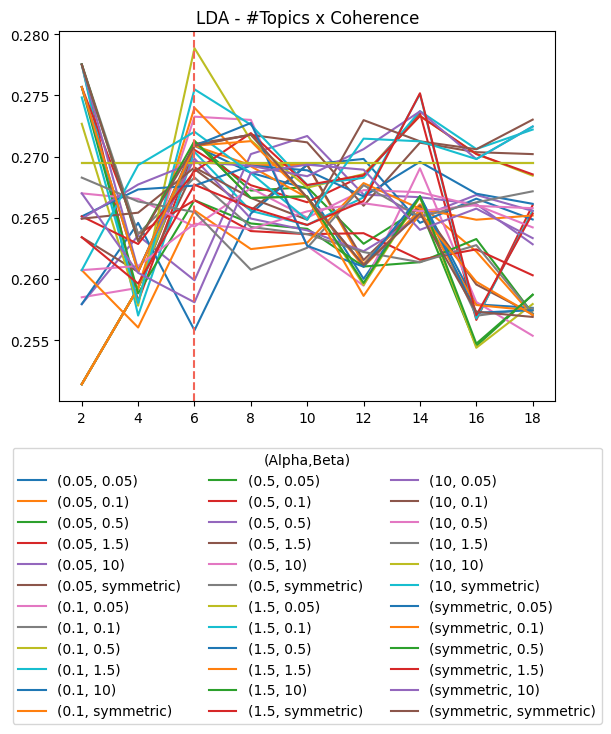

In [16]:
f = plt.figure()
plt.title('LDA - #Topics x Coherence', color='black')
ax = s.groupby(['alpha', 'beta'])['cv'].plot(ax=f.gca())

plt.legend(loc='center', bbox_to_anchor=(0.5, -0.5), ncols=3, title="(Alpha,Beta)")
plt.axvline(best_k,color="#F26457",linestyle="--")
plt.show()

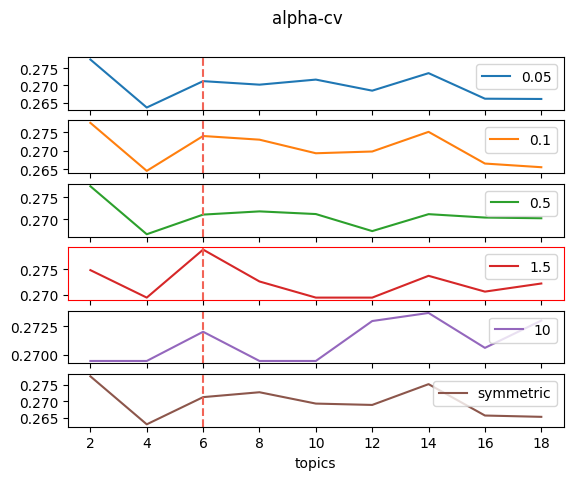

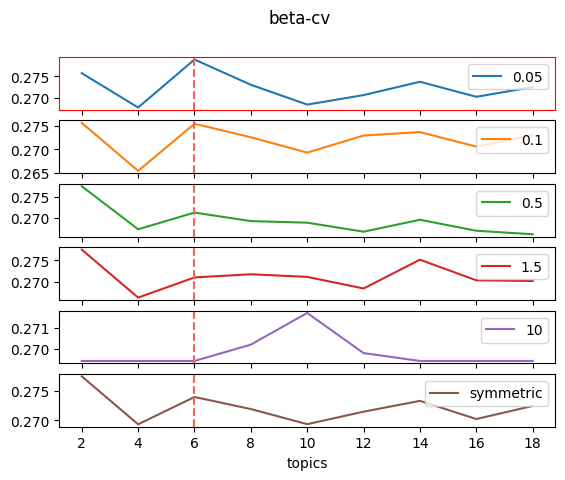

In [17]:

columns=['alpha','beta']
values=['cv']
from pprint import pprint

# plot counter
for c in columns:
    for v in values:
        max_cv = np.argmax(s[v]) if v != "perp" else np.argmin(s[v])
        max_k = int(results.Topics.values[max_cv]) 
        ax = pd.pivot_table(s.groupby(by=["topics",c]).max(v).reset_index(),
               index='topics', columns=c, values=v
              ).plot(subplots=True, title=f"{c}-{v}")        
        for x in ax:            
            leg = x.axes.get_legend()                                
            txt = leg.texts[0].get_text()
            if str(txt) == str(best[c]):
                for spine in x.spines.values():                    
                    spine.set_edgecolor('red')
            x.axvline(max_k,color="#F26457",linestyle="--")                
            x.legend(loc='upper right', frameon=True)            
            plt.gcf().savefig('images/cv-lda-{}.png'.format(c),dpi=150)

In [175]:
best_lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=best_k,
                                                random_state=1234,
                                                iterations=100,
                                                chunksize=10000,
                                                passes=1,
                                                alpha=float(best_a),
                                                eta=float(best_b),  
                                                per_word_topics=True)

In [192]:
#best_lda_model = gensim.models.ldamulticore.LdaMulticore.load('data/models/lda_model_2_0.1_1.5')
#best_k=2

In [16]:
!pip install wordcloud

In [18]:
from wordcloud import WordCloud

In [19]:
long_string = " ".join([item for t in texts for item in t])

In [20]:
wordcloud = WordCloud(background_color="white",max_words=1000,contour_width=3,contour_color='steelblue')

In [21]:
wordcloud.generate(long_string)

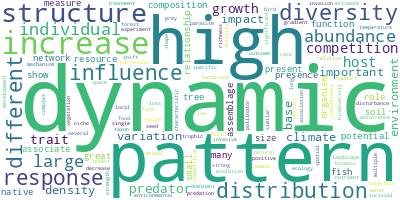

In [22]:
wordcloud.to_image()

In [257]:
lda_doc_top = [v[1] for item in corpus for v in best_lda_model.get_document_topics(item, minimum_probability=0)]

In [258]:
lda_doc_top = np.reshape(lda_doc_top, (len(texts_nonnull), best_k))
lda_doc_top

array([[0.14498243, 0.20362838, 0.1289533 , 0.20596592, 0.13454719,
        0.18192278],
       [0.18125124, 0.19342253, 0.14121771, 0.18812852, 0.12310027,
        0.17287971],
       [0.30553773, 0.10754263, 0.10313963, 0.1408201 , 0.12593618,
        0.21702375],
       ...,
       [0.04723499, 0.03680656, 0.0526839 , 0.5022895 , 0.28663537,
        0.07434972],
       [0.0674208 , 0.07325637, 0.13429646, 0.07827824, 0.56129295,
        0.08545519],
       [0.26970306, 0.46308798, 0.19092637, 0.02530858, 0.02504293,
        0.02593107]], dtype=float32)

In [259]:
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=best_k, n_init=5, random_state=100, max_iter=1000).fit_predict(lda_doc_top)
clusters

array([3, 3, 3, ..., 0, 5, 4], dtype=int32)

In [260]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#svd_model = make_pipeline(TruncatedSVD(n_components=2))
svd_model = TruncatedSVD(n_components=2)

In [261]:
lda_output_svd = svd_model.fit_transform(lda_doc_top)
x = lda_output_svd[:,0]
y = lda_output_svd[:,1]

In [262]:
print("Component's weights: \n", np.round(svd_model.components_, 2))

Component's weights: 
 [[ 0.41  0.41  0.4   0.41  0.4   0.41]
 [-0.26 -0.14 -0.21  0.62 -0.51  0.48]]


In [263]:
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Perc of Variance Explained: 
 [0.   0.21]


In [125]:
len(texts)

13701

In [285]:
df = pd.read_csv("data/dimensions/publications-ecology-filtered-13701.csv")

In [286]:
lens = np.asarray([len(t) for t in texts])
df = df.loc[lens>0,]

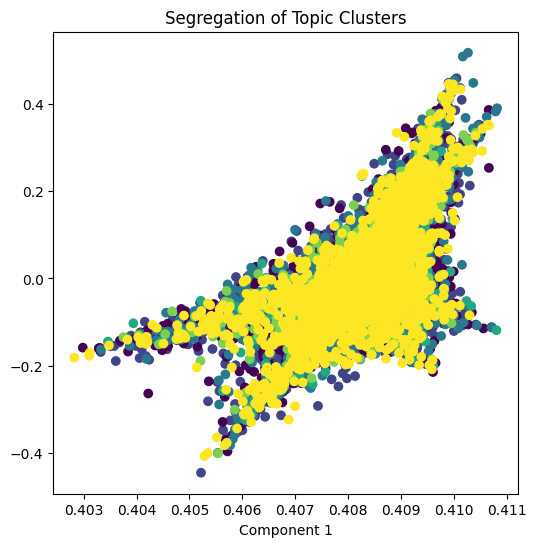

In [267]:
plt.figure(figsize=(6, 6))
color_dict = { 'biotic interaction':0, 'species interaction':1, 'ecological interaction':2, 'community interaction':3,'biological interaction':4, 'interspecific interaction':5 }
plt.scatter(x, y, c=[color_dict[i] for i in df["GROUP"]], alpha=1)
#plt.scatter(x, y, c=clusters, alpha=1, cmap='Set1')
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )
plt.gcf().savefig('images/topics-svd-int-terms.png', dpi=150)

Text(0.5, 1.0, 'Segregation of Topic Clusters')

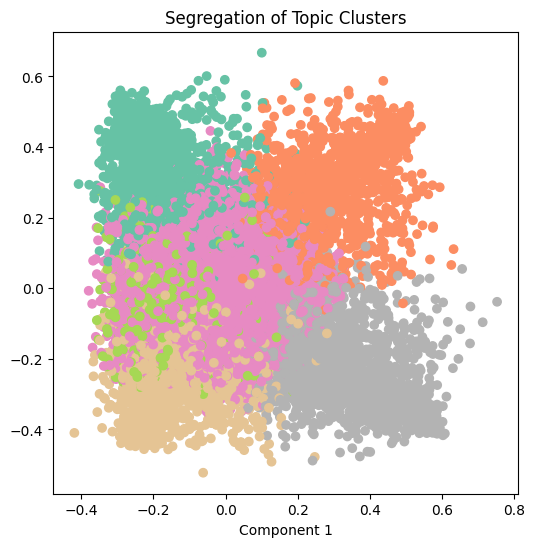

In [232]:
#PCA
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

pipeline = make_pipeline(Normalizer(copy=False), PCA(n_components=2))
pca = pipeline.fit_transform(lda_doc_top)        
plt.figure(figsize=(6, 6))
#color_dict = { 'biotic interaction':0, 'species interaction':1, 'ecological interaction':2, 'community interaction':3,'biological interaction':4, 'interspecific interaction':5 }
#plt.scatter(pca[:,0], pca[:,1], c=[color_dict[i] for i in df["GROUP"]], alpha=1, cmap="Set1")
plt.scatter(pca[:,0], pca[:,1], c=clusters, alpha=1, cmap='Set2')
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters")

# Number of documents per topic

In [130]:
doc_topics = best_lda_model.get_document_topics(corpus, minimum_probability=0)

In [131]:
arr = [np.asarray(t) for t in doc_topics]
doc_topics_id = [a[np.argmax(a[:,1])][0] for a in arr]
_, counts = np.unique(doc_topics_id, return_counts=True)
counts

array([2324, 2409, 2124, 2227, 2158, 2284])

# Dominant topic and its percentage contribution in each document

In [177]:
sent_topics = []

for i,row_list in enumerate(best_lda_model[corpus]):
    row = row_list[0] if best_lda_model.per_word_topics else row_list
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j,(topic_num,prop_topic) in enumerate(row):
        if j == 0:
            wp = best_lda_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word,prop in wp])
            sent_topics.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]))
        else:
            break
sent_topics_df = pd.DataFrame(sent_topics)
sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic Keywords']
contents = pd.Series(texts_nonnull)
sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
sent_topics_df[:2]

,Dominant_Topic,Perc_Contribution,Topic Keywords,0
0,3,0.2062,"pattern, diversity, high, response, dynamic, individual, host, structure, influence, distribution","[integrative, context_dependent, long_know, outcome, environmental_context, climate, spark, cont..."
1,1,0.1933,"diversity, distribution, increase, high, large, pattern, trait, individual, predator, dynamic","[predictability, response_environmental, global, ecologist, current, spatial, shift_distribution..."


In [143]:
df_dominant_topic = sent_topics_df.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.2059,"pattern, diversity, high, response, dynamic, individual, host, structure, influence, distribution","[integrative, context_dependent, long_know, outcome, environmental_context, climate, spark, cont..."
1,1,1,0.1936,"diversity, distribution, increase, high, large, pattern, trait, individual, predator, dynamic","[predictability, response_environmental, global, ecologist, current, spatial, shift_distribution..."
2,2,0,0.3055,"host, abundance, large, growth, structure, influence, network, competition, distribution, variation","[parasite, meta, ubiquitous_nature, parasitism, parasitism, alter_outcome, host, competition_mut..."
3,3,4,0.3274,"structure, increase, response, pattern, abundance, growth, distribution, dynamic, environment, c...","[disentangle, diverse, heterogeneous, bayesian, modelling, diverse_community, large, especially_..."
4,4,2,0.3529,"dynamic, structure, diversity, influence, high, competition, large, different, climate, pattern","[impact, tree, role, reduction, distinct, photosynthetic_response, warm, drought, remain_unclear..."
5,5,1,0.4241,"diversity, distribution, increase, high, large, pattern, trait, individual, predator, dynamic","[darwin_naturalization, conundrum, phylogenetic, native_exotic, close, still_unclear, environmen..."
6,6,2,0.2787,"dynamic, structure, diversity, influence, high, competition, large, different, climate, pattern","[mutualistic, last, long, antagonistic, crucial, ubiquitous, organism_however, remain_unclear, l..."
7,7,2,0.2700,"dynamic, structure, diversity, influence, high, competition, large, different, climate, pattern","[role, forest, increase, frequency, drought, climate, sustainable, function, forest, admixture, ..."
8,8,1,0.2538,"diversity, distribution, increase, high, large, pattern, trait, individual, predator, dynamic","[predictable, impact, diversification, fundamental_ecology, generality, myriad, competition_mutu..."
9,9,2,0.2197,"dynamic, structure, diversity, influence, high, competition, large, different, climate, pattern","[structure, persistence, shape, maintenance_biodiversity, integrate, mathematical, detailed, exp..."


# The most representative sentence for each topic

In [144]:
pd.options.display.max_colwidth = 100

In [145]:
sent_topics_sorted_df = pd.DataFrame()
sent_topics_out_grpd = sent_topics_df.groupby(by='Dominant_Topic')

In [146]:
for i, grp in sent_topics_out_grpd:
    sent_topics_sorted_df = pd.concat([sent_topics_sorted_df, grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], axis=0)

sent_topics_sorted_df.reset_index(drop=True, inplace=True)
sent_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorted_df.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.8461,"host, abundance, large, growth, structure, influence, network, competition, distribution, variation","[density_dependent, growth_survival, natural, facultative, biennial, density_dependent, effect_v..."
1,1,0.8960,"diversity, distribution, increase, high, large, pattern, trait, individual, predator, dynamic","[theoretical, templet, trait, richness, upper_rhone, river_floodplain, prediction, templet, rela..."
2,2,0.8265,"dynamic, structure, diversity, influence, high, competition, large, different, climate, pattern","[nutrition, environmental_response, nutrition, influence, animal_ecology, juvenile_growth, adult..."
3,3,0.8734,"pattern, diversity, high, response, dynamic, individual, host, structure, influence, distribution","[restoration, pollinator_network, ancient, restore, heathlands, damage, structural, aspect_biodi..."
4,4,0.9010,"structure, increase, response, pattern, abundance, growth, distribution, dynamic, environment, c...","[social, competition, similar, rodent, geographical_range, competition, space, network, competit..."
5,5,0.8533,"dynamic, high, increase, predator, different, pattern, influence, trait, response, individual","[biology_ecology, lotic, hydracarina, acari, freshwater, abundant, speciose, low, contain, benth..."


# Frequency distribution of Word Counts in Documents

In [147]:
doc_lens = np.asarray([len(d) for d in df_dominant_topic.Text])

In [148]:
df_dominant_topic[np.asarray(doc_lens) == 0]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text


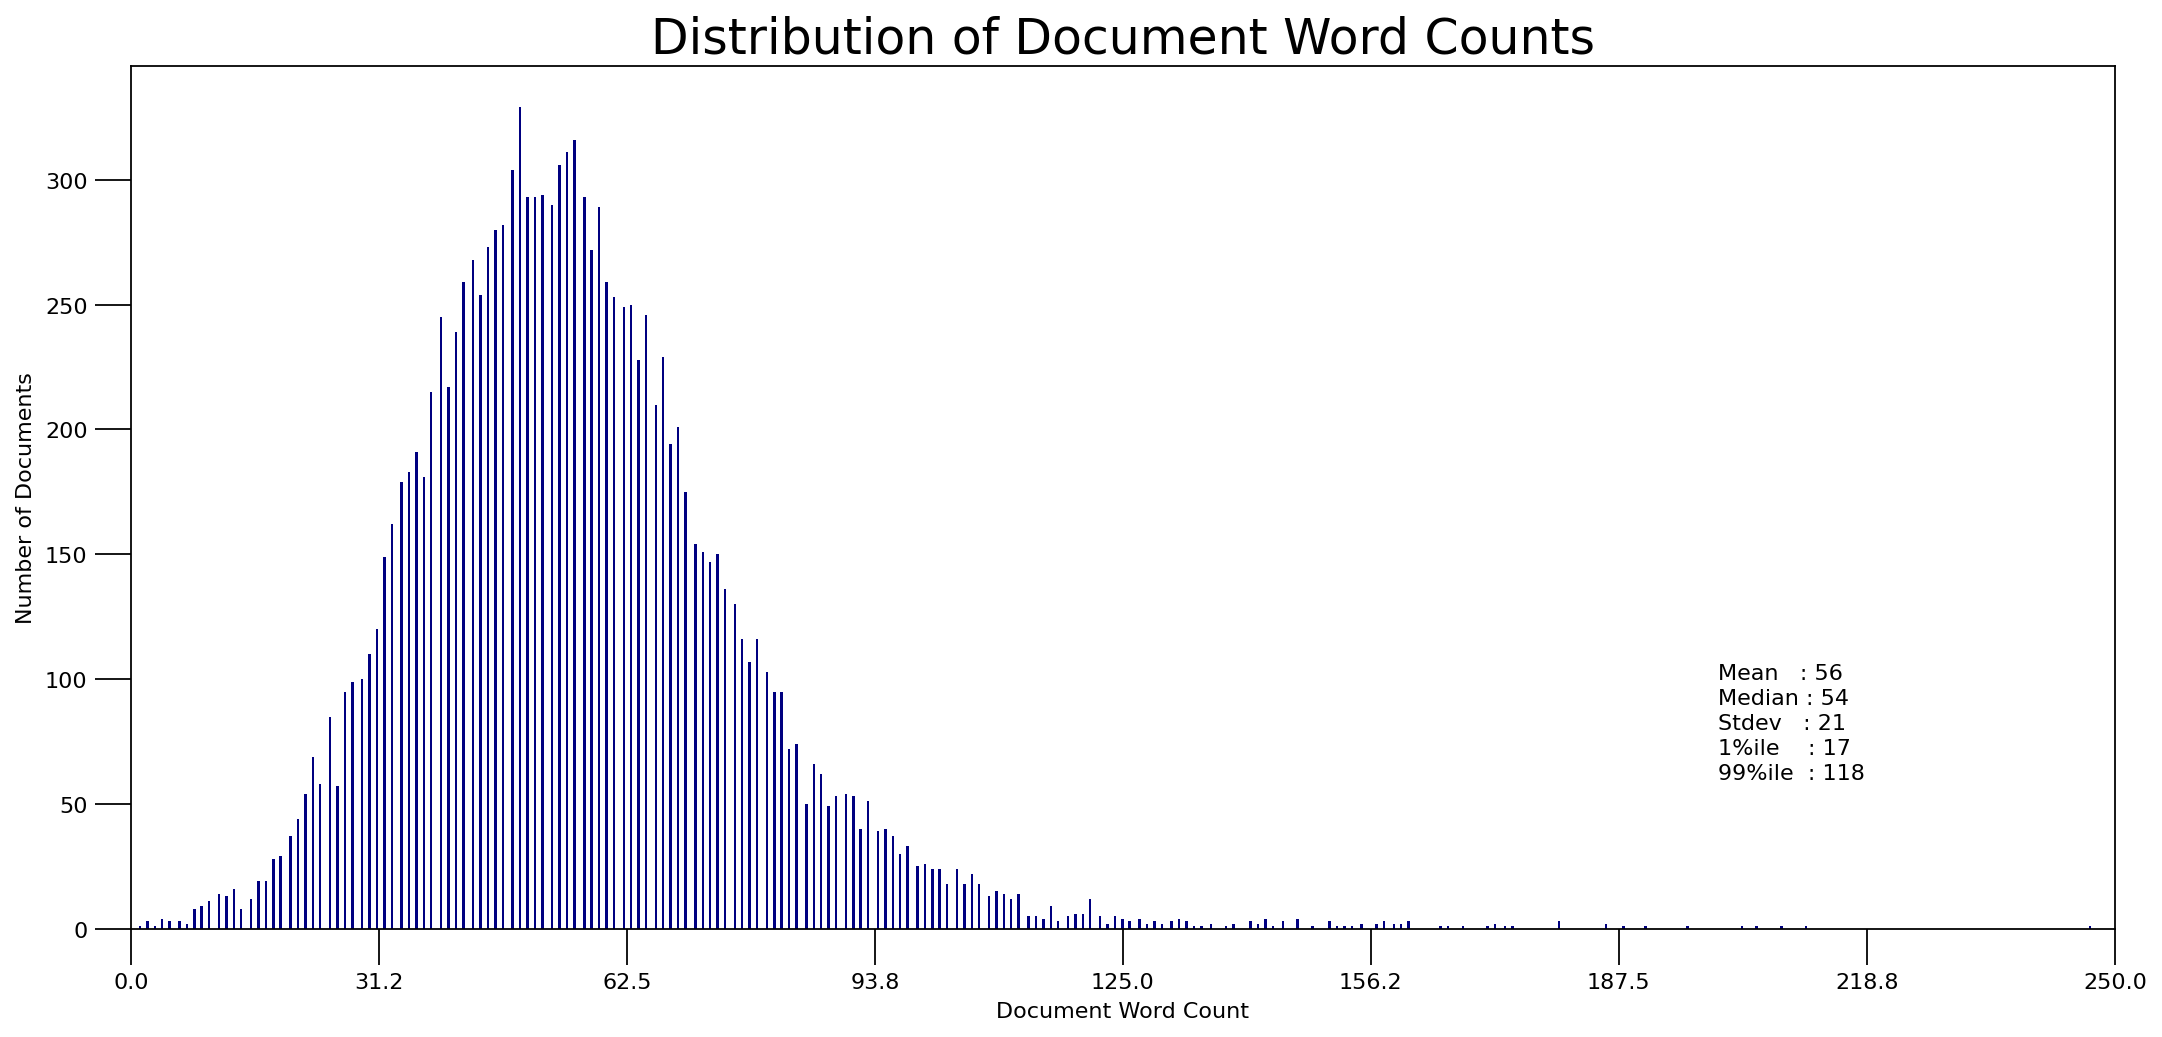

In [149]:
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins=1000,color='navy')
plt.text(200, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(200,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(200,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(200,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(200,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 250), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,250,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [40]:
!pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


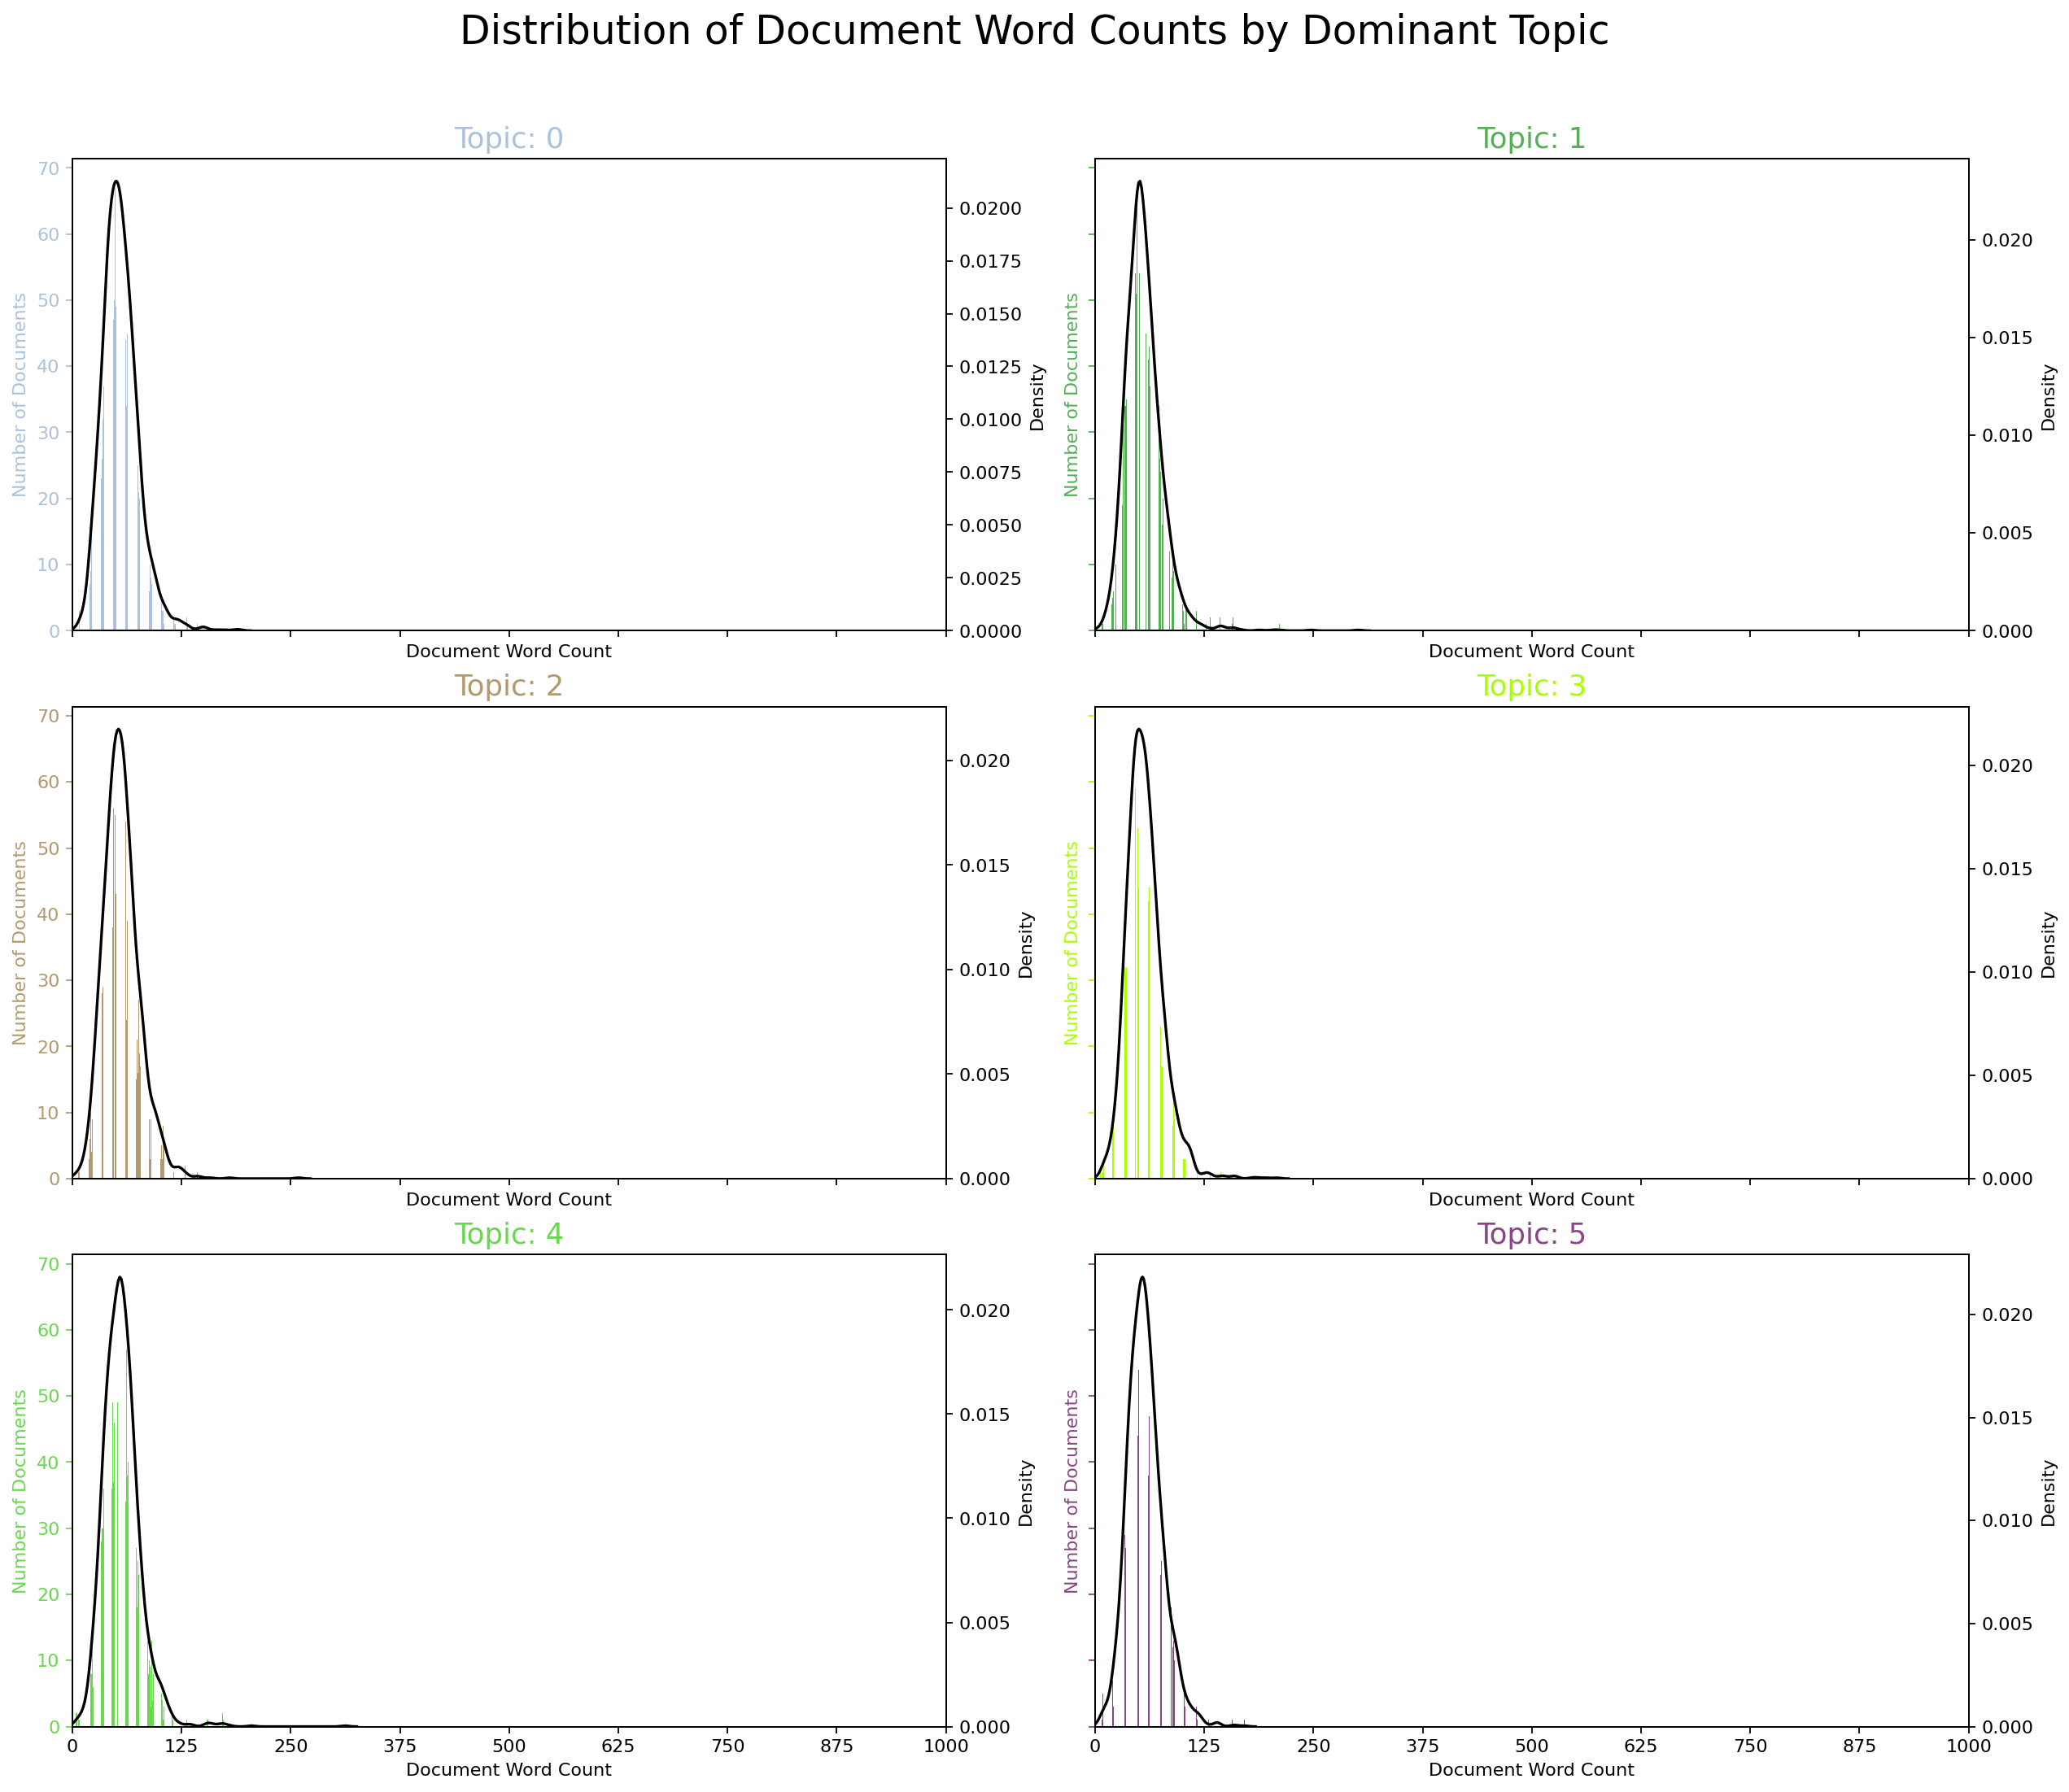

In [150]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", fill=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# Word Clouds of Top N Keywords in each Topic

In [268]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [349]:
cols = [color for name, color in mcolors.XKCD_COLORS.items()]

In [350]:
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

In [271]:
topics = best_lda_model.show_topics(num_topics=best_k, formatted=False, num_words=15)
topics[1][1]

[('diversity', 0.0048762714),
 ('distribution', 0.004171332),
 ('increase', 0.0041703973),
 ('high', 0.0034504428),
 ('large', 0.003217335),
 ('pattern', 0.0031781697),
 ('trait', 0.0029796427),
 ('individual', 0.002948915),
 ('predator', 0.0027723424),
 ('dynamic', 0.0027094756),
 ('abundance', 0.002622893),
 ('base', 0.002610278),
 ('different', 0.0026101393),
 ('associate', 0.0025327613),
 ('growth', 0.0025270646)]

biotic interaction
species interaction
ecological interaction
community interaction
biological interaction
interspecific interaction


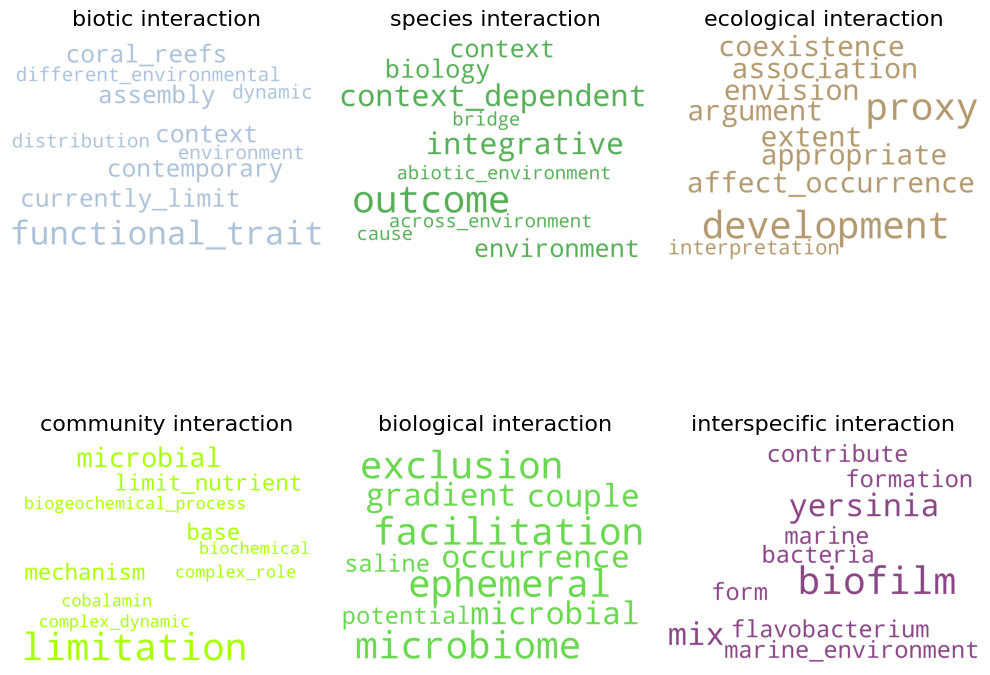

In [358]:
# DTM
from sklearn.feature_extraction.text import CountVectorizer
terms = ['biotic interaction', 'species interaction', 'ecological interaction', 'community interaction','biological interaction', 'interspecific interaction']
fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)
axes = axes.flatten()

for i,k in enumerate(terms):
    print(k)
    idx = df[df["GROUP"]==k].index    
    texts_k = [texts[i] for i in range(0,len(texts)) if i in idx]    
    vectorizer = CountVectorizer(analyzer="word",stop_words='english',lowercase=True)
    corpus = [" ".join(t) for t in texts_k]
    dtm = vectorizer.fit_transform(corpus)    
    names = vectorizer.get_feature_names_out()
    words = dict([(names[i],f) for i,f in enumerate(dtm.toarray()[0]) if f > 0])
    fig.add_subplot(axes[i])    
    cloud.generate_from_frequencies(words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(k, fontdict=dict(size=16))
    plt.gca().axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
fig.savefig('images/wordcloud-int-terms.png', dpi=150)
plt.show()

    
    


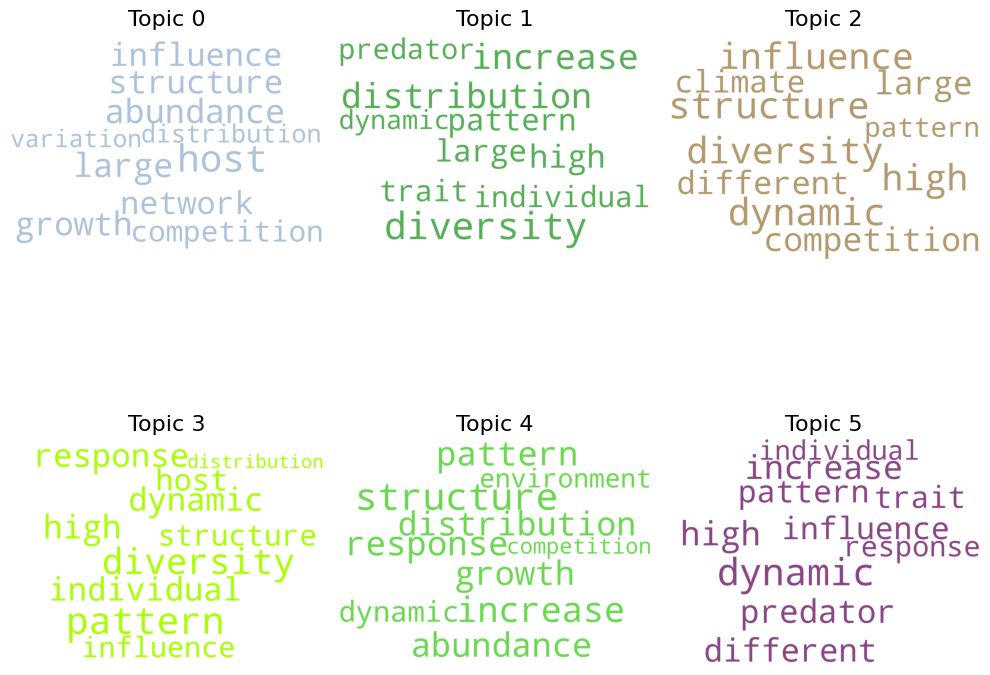

In [352]:
fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
fig.savefig('images/wordcloud-topics.png', dpi=150)
plt.show()

# Word Counts of Topic Keywords

/tmp/ipykernel_2425881/3968761424.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


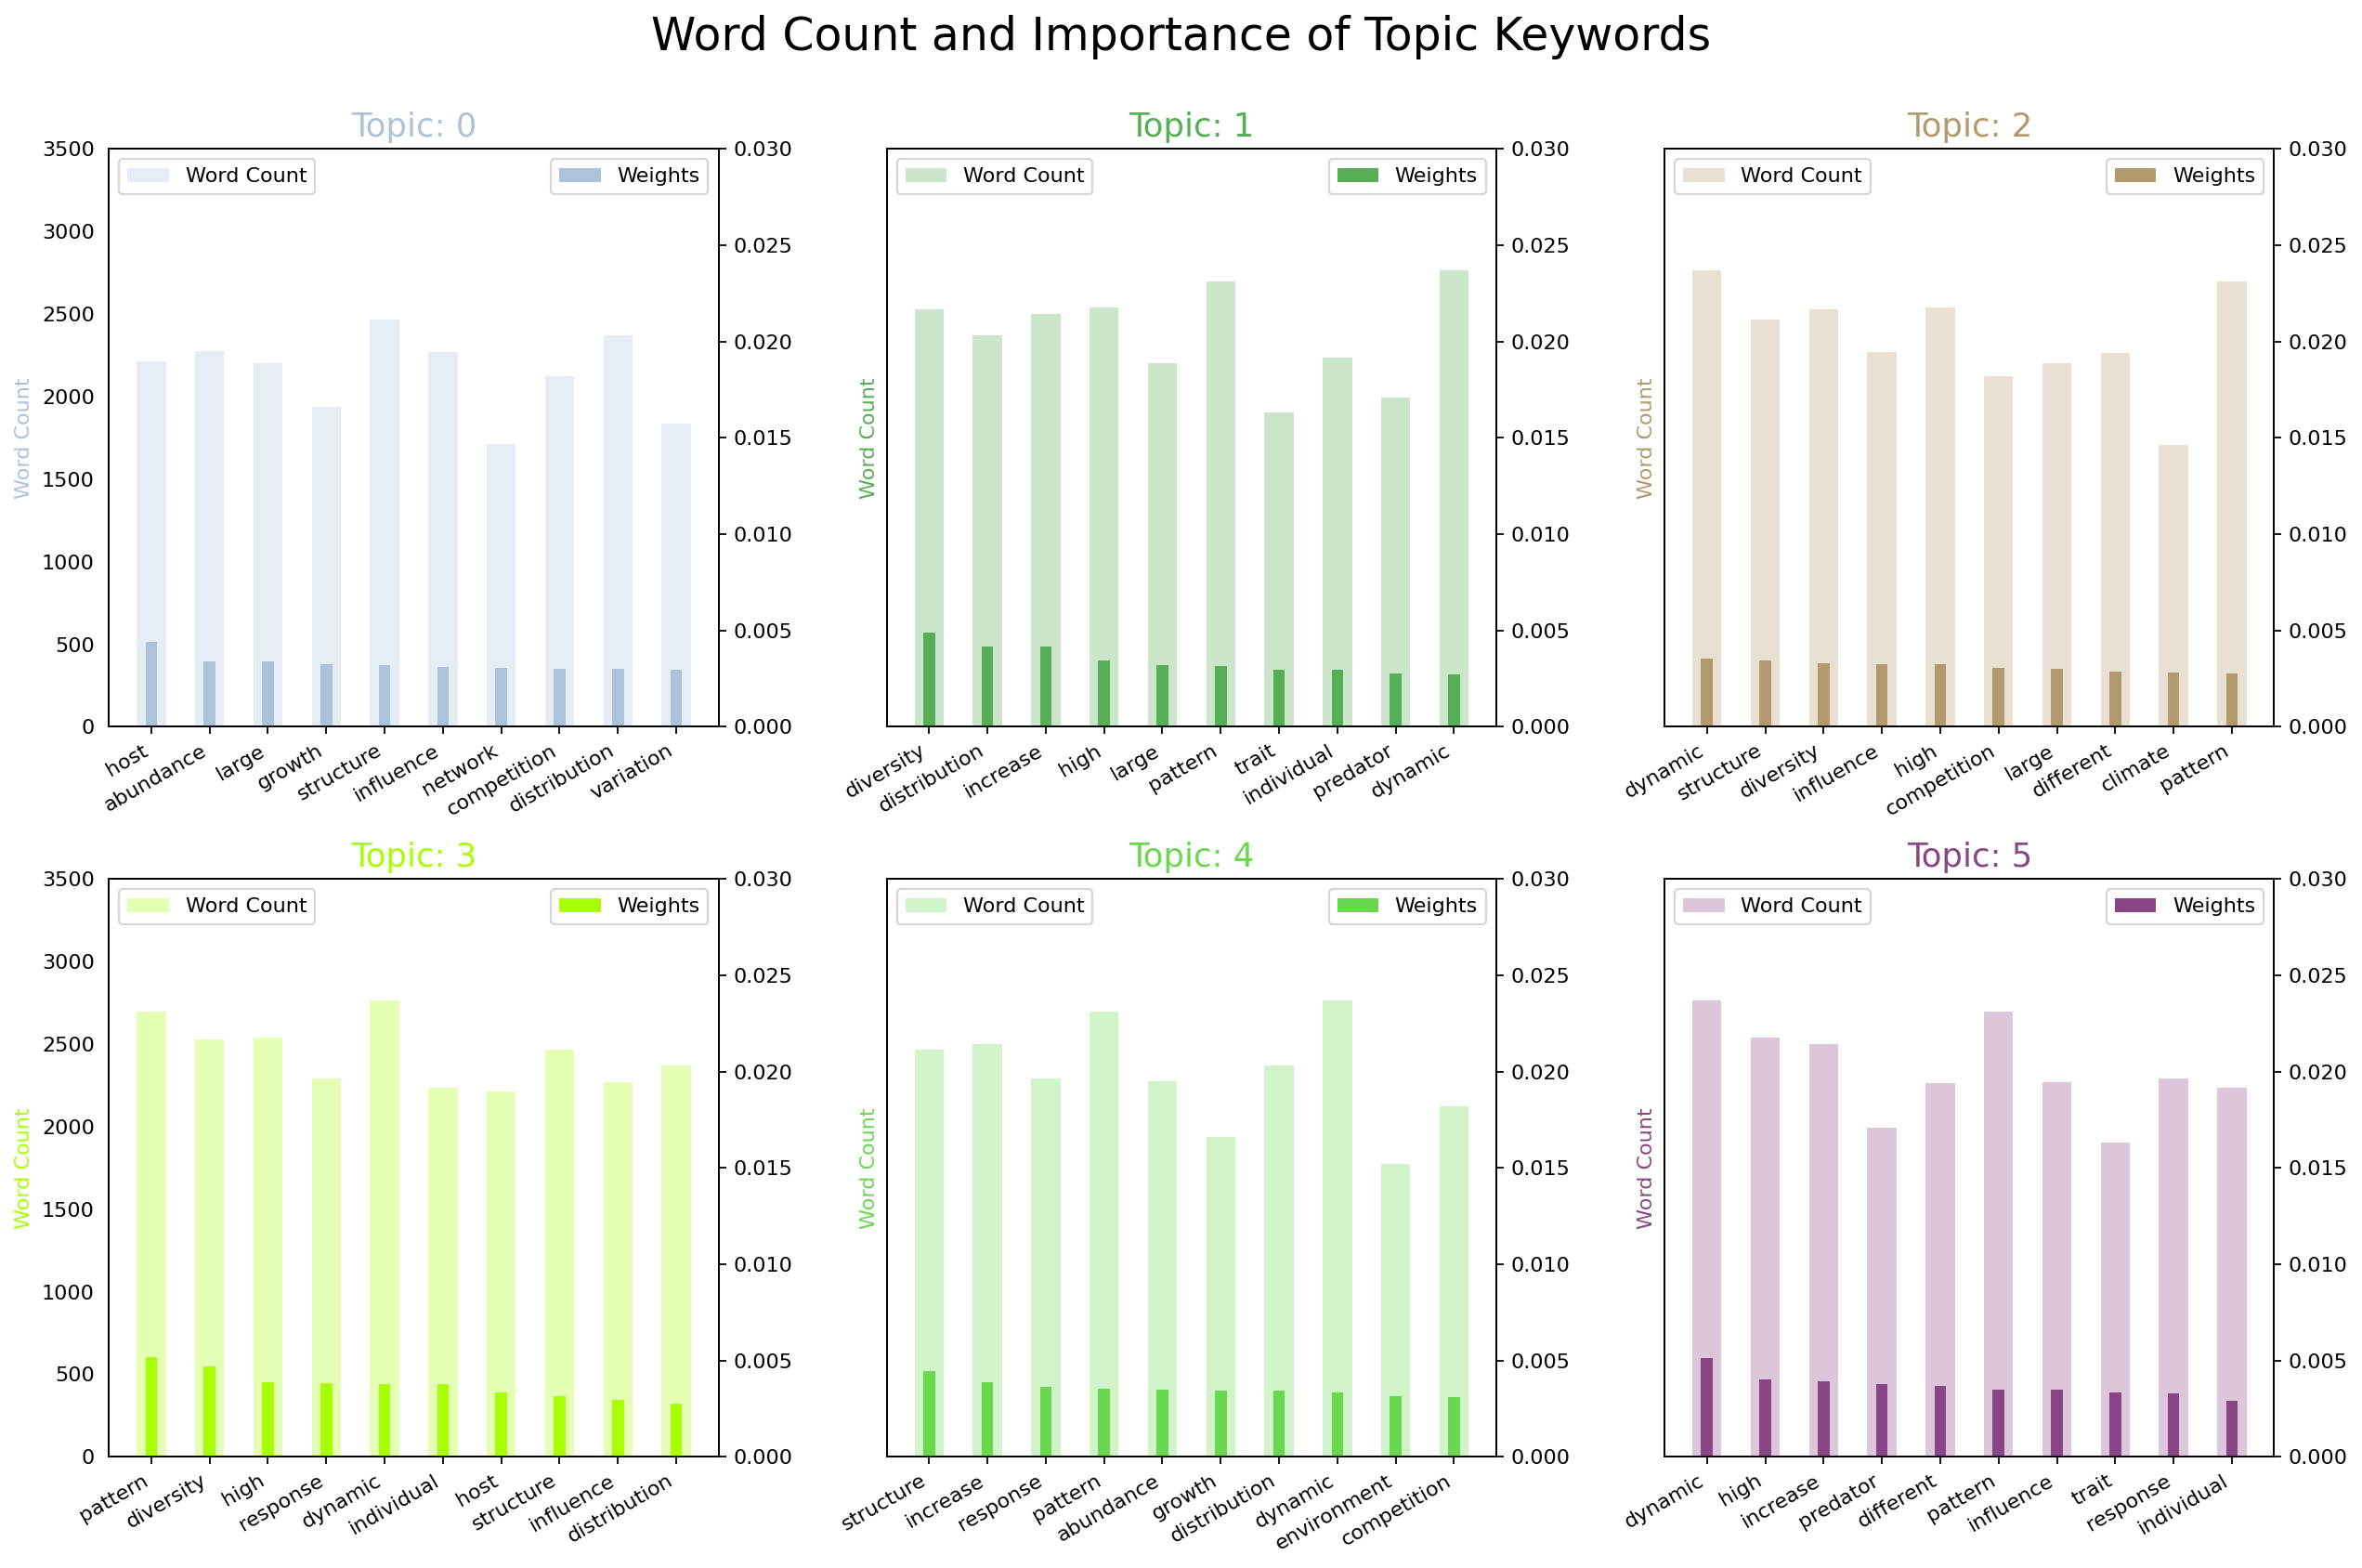

In [165]:
from collections import Counter
topics = best_lda_model.show_topics(num_topics=best_k,formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_words = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_words.loc[df_words.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_words.loc[df_words.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_words.loc[df_words.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# Sentence Chart Colored by Topic

In [174]:
best_lda_model[corpus[1]]

[(0, 0.18145563),
 (1, 0.19348425),
 (2, 0.14112319),
 (3, 0.18815143),
 (4, 0.12313194),
 (5, 0.17265357)]

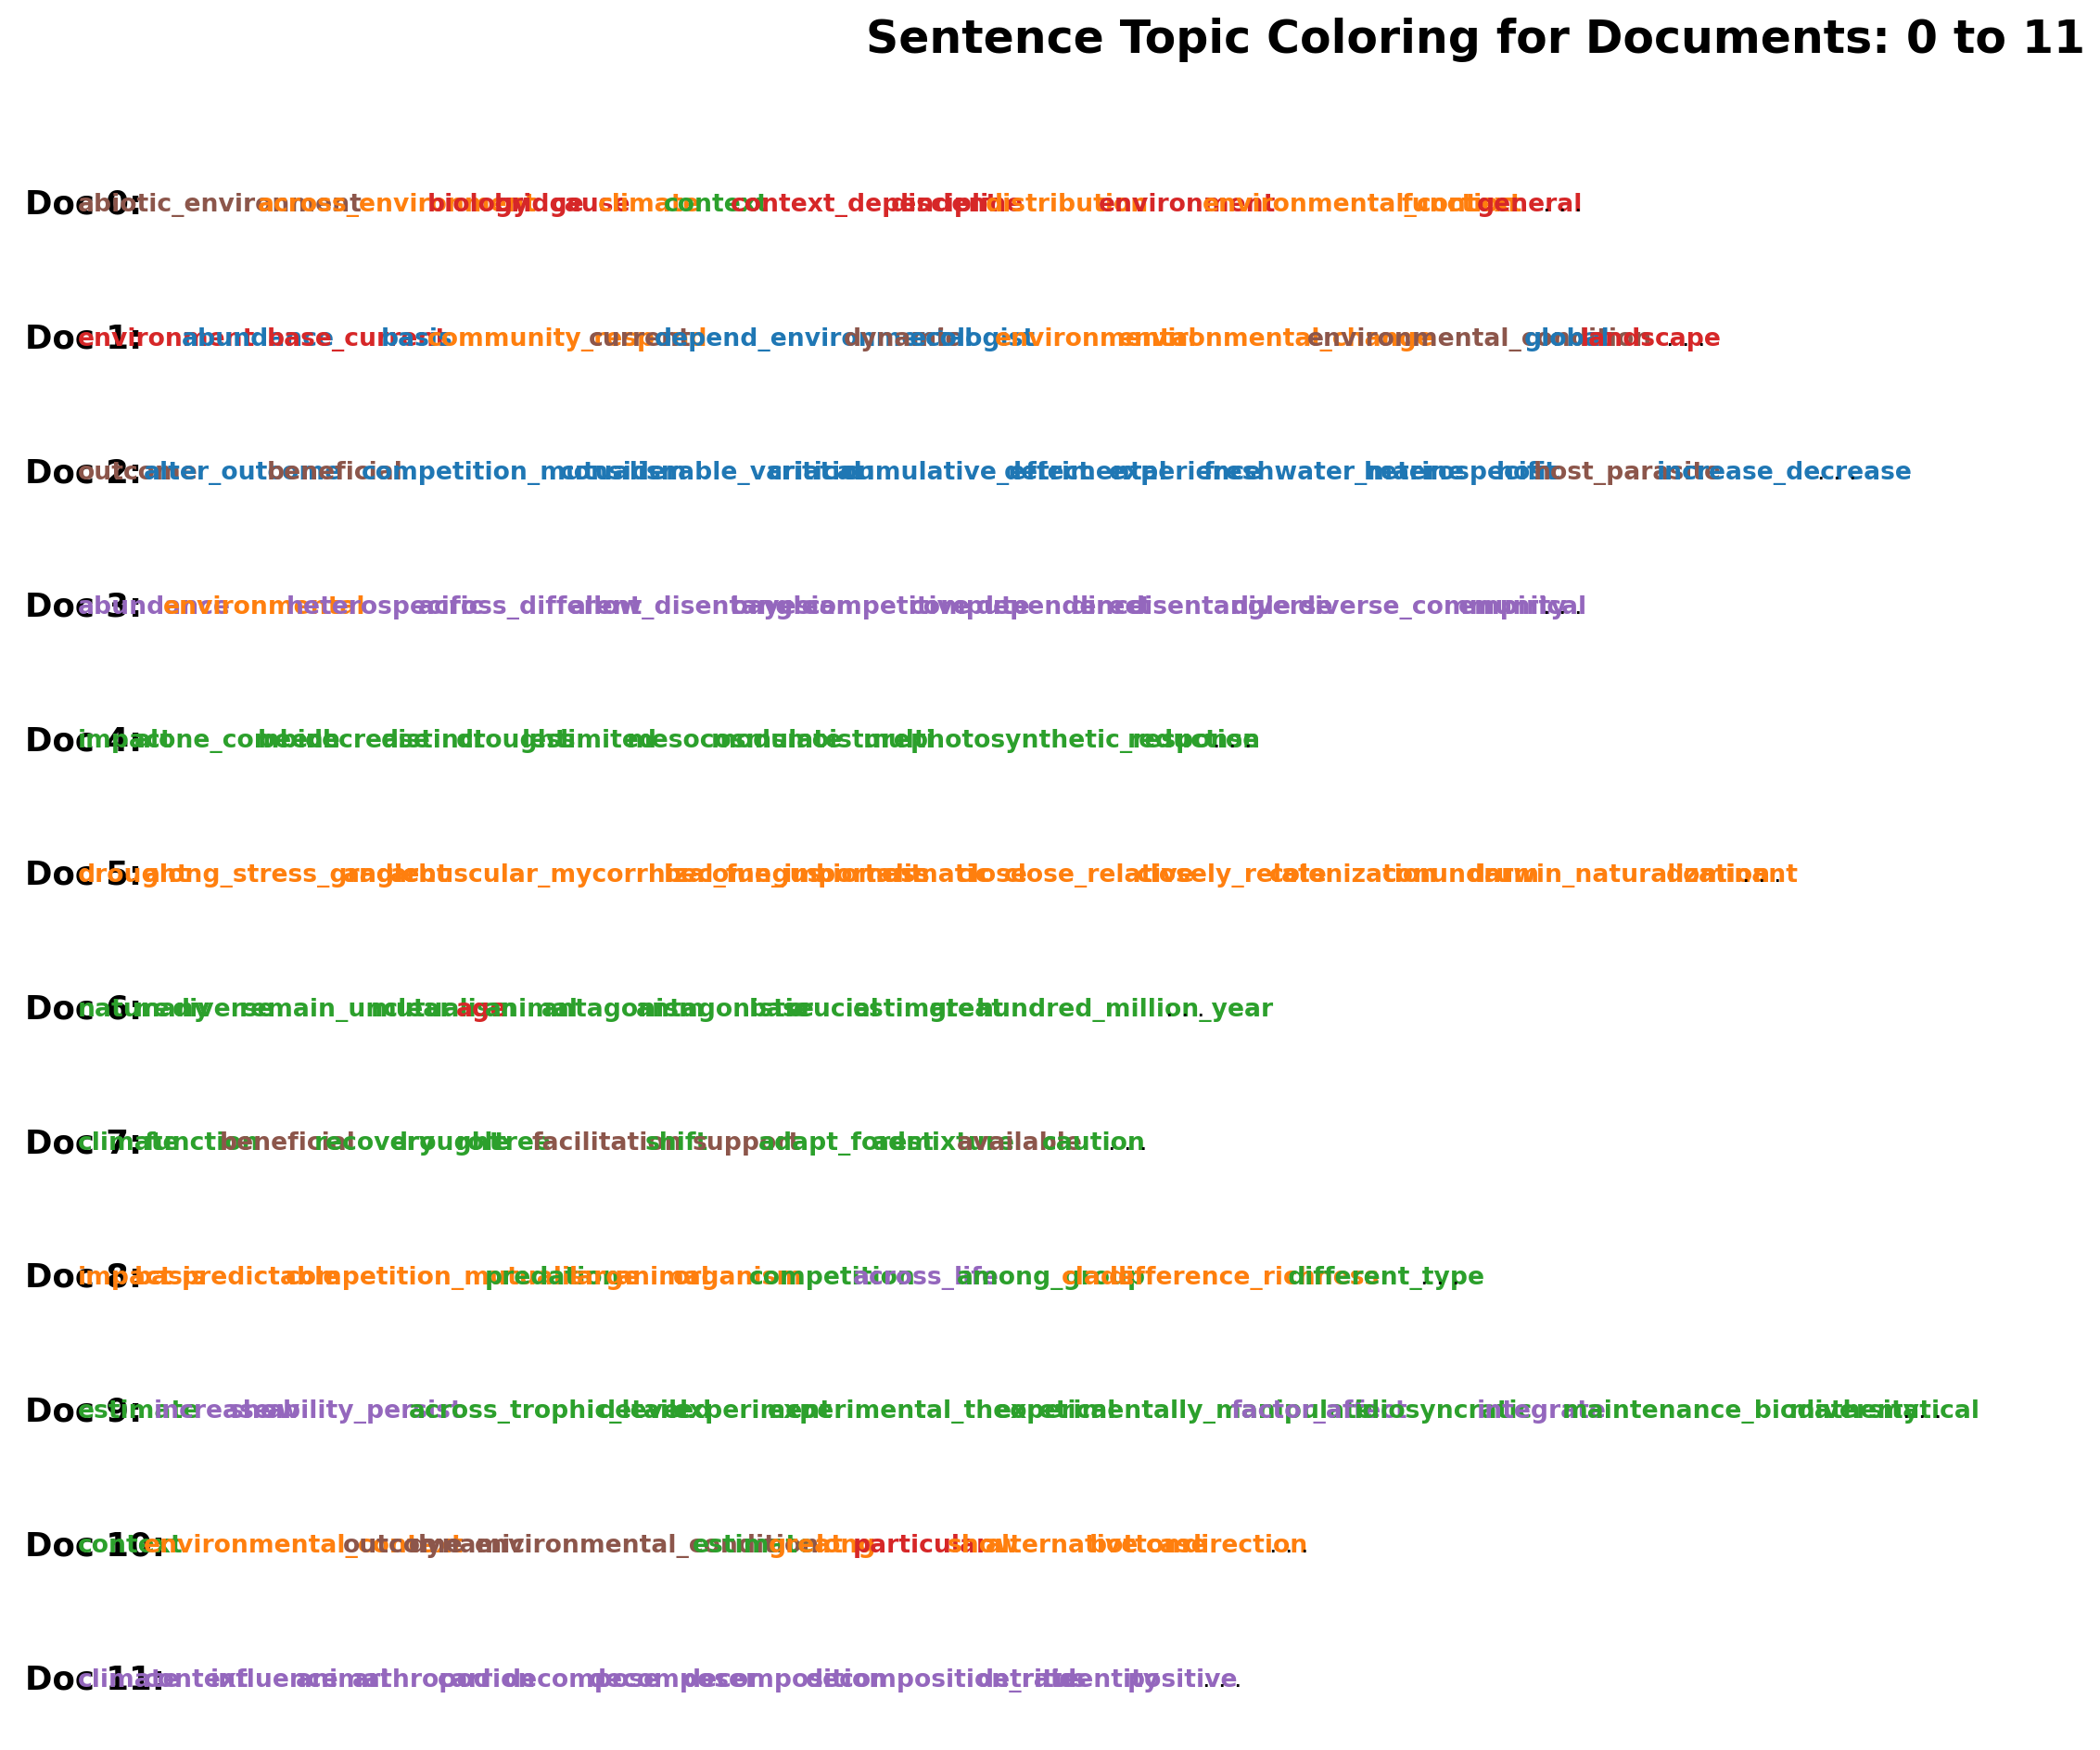

In [181]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            #ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
             #                      color=mycolors[topic_percs_sorted[0][0]], linewidth=1))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=12, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=12, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart(best_lda_model)    

# t-SNE Clustering Chart

In [88]:
!pip install bokeh

  Using cached bokeh-3.1.1-py3-none-any.whl (8.3 MB)
  Using cached xyzservices-2023.5.0-py3-none-any.whl (56 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [207]:
from sklearn.manifold import TSNE
#from bokeh.plotting import figure, output_file, show
#from bokeh.models import Label
#from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(best_lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
#arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13526 samples in 0.009s...
[t-SNE] Computed neighbors for 13526 samples in 0.579s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13526
[t-SNE] Computed conditional probabilities for sample 2000 / 13526
[t-SNE] Computed conditional probabilities for sample 3000 / 13526
[t-SNE] Computed conditional probabilities for sample 4000 / 13526
[t-SNE] Computed conditional probabilities for sample 5000 / 13526
[t-SNE] Computed conditional probabilities for sample 6000 / 13526
[t-SNE] Computed conditional probabilities for sample 7000 / 13526
[t-SNE] Computed conditional probabilities for sample 8000 / 13526
[t-SNE] Computed conditional probabilities for sample 9000 / 13526
[t-SNE] Computed conditional probabilities for sample 10000 / 13526
[t-SNE] Computed conditional probabilities for sample 11000 / 13526
[t-SNE] Computed conditional probabilities for sample 12000 / 13526
[t-SNE] Computed conditional probabilities for sam

In [204]:
df.GROUP

0              species interaction
1              species interaction
2              species interaction
3              species interaction
4              species interaction
                   ...            
13696    interspecific interaction
13697    interspecific interaction
13698    interspecific interaction
13699    interspecific interaction
13700    interspecific interaction
Name: GROUP, Length: 13701, dtype: object

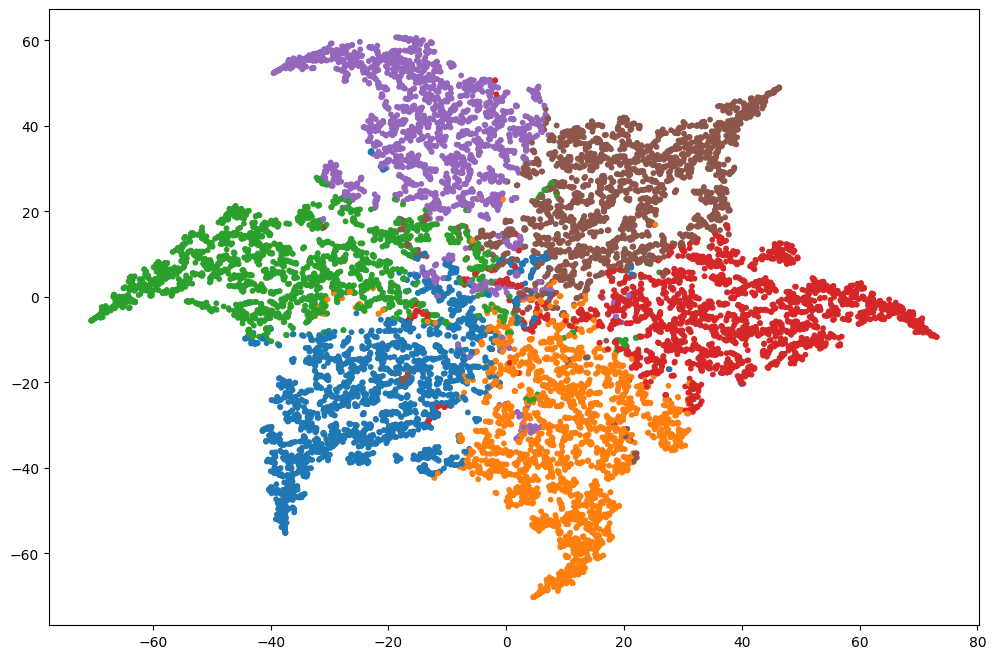

In [278]:
# Plot the Topic Clusters using Bokeh
#output_notebook()
n_topics = best_k
color_dict = { 'biotic interaction':0, 'species interaction':1, 'ecological interaction':2, 'community interaction':3,'biological interaction':4, 'interspecific interaction':5 }

mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
#plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              #width=900, height=700)
#plt.scatter(pca[:,0], pca[:,1], c=[color_dict[i] for i in df["GROUP"]], alpha=1, cmap="Set1")
f, ax  = plt.subplots(figsize=(12,8))
#ax.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], c=[color_dict[i] for i in df["GROUP"]], s=10, cmap="Set1")
ax.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num], s=10)
#show(plot)
f.savefig('images/tsne-topics.png', dpi=150)